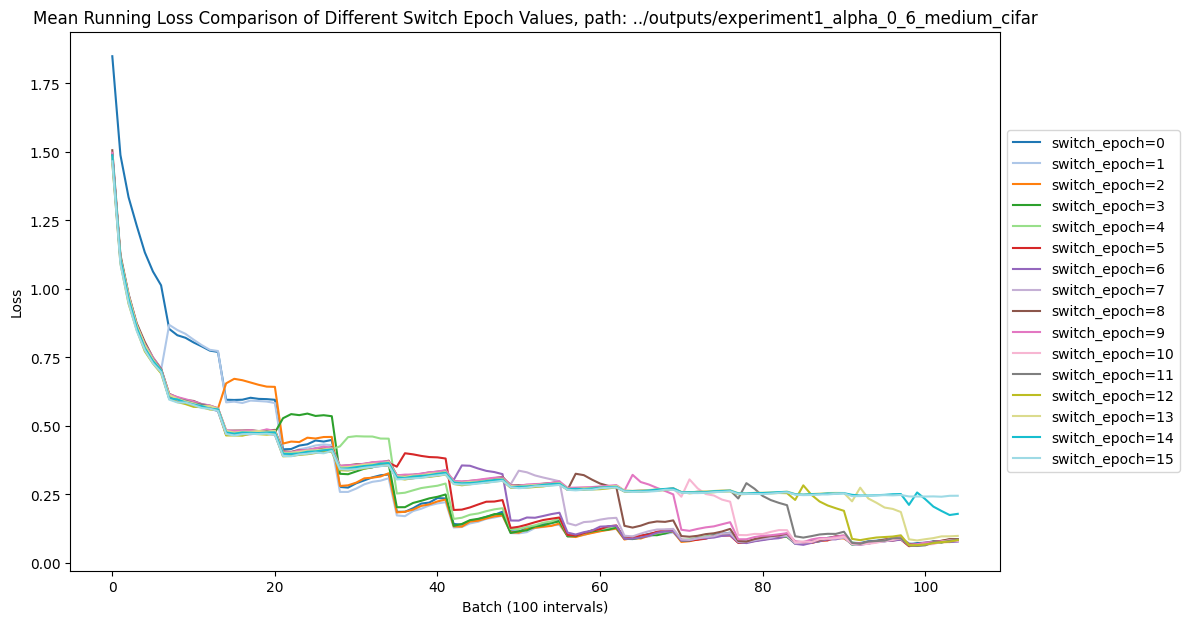

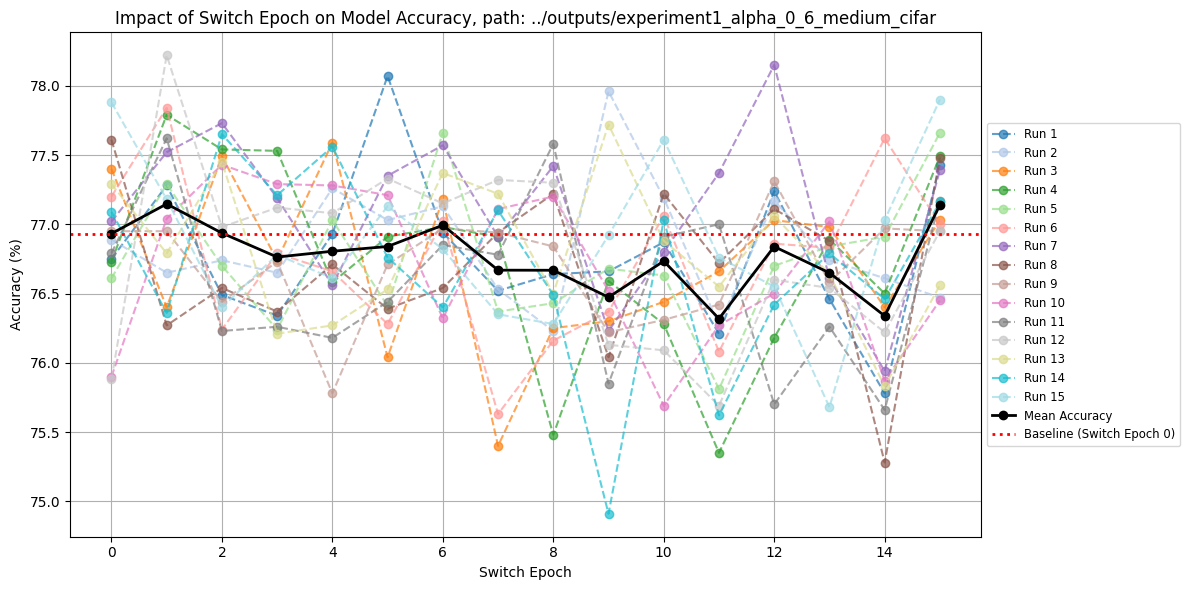

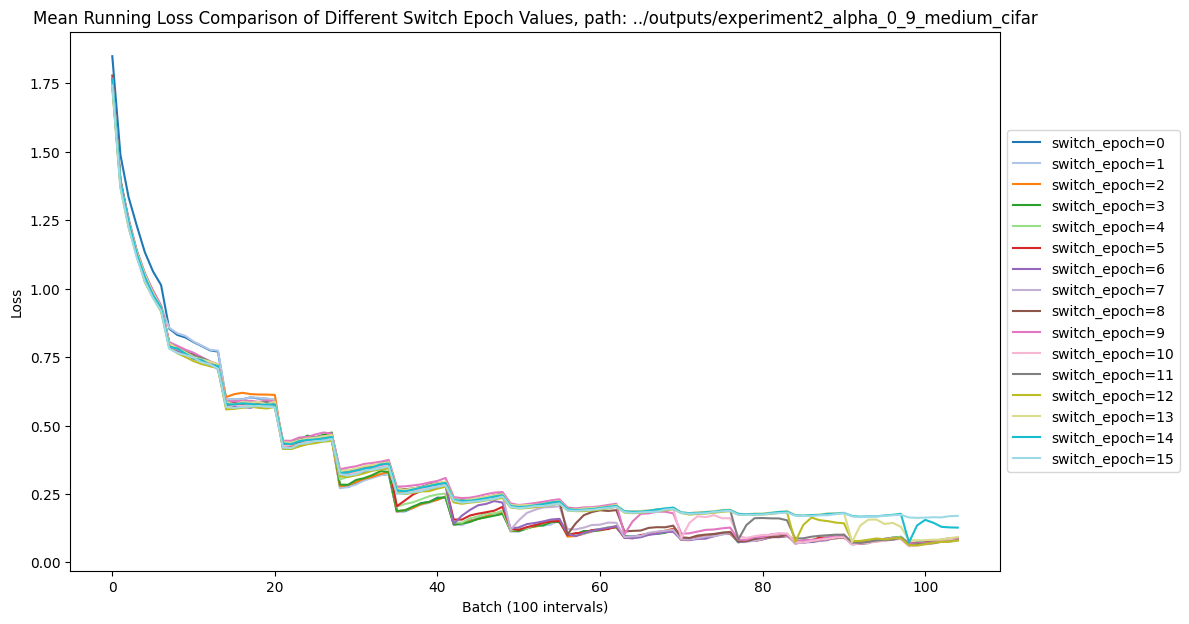

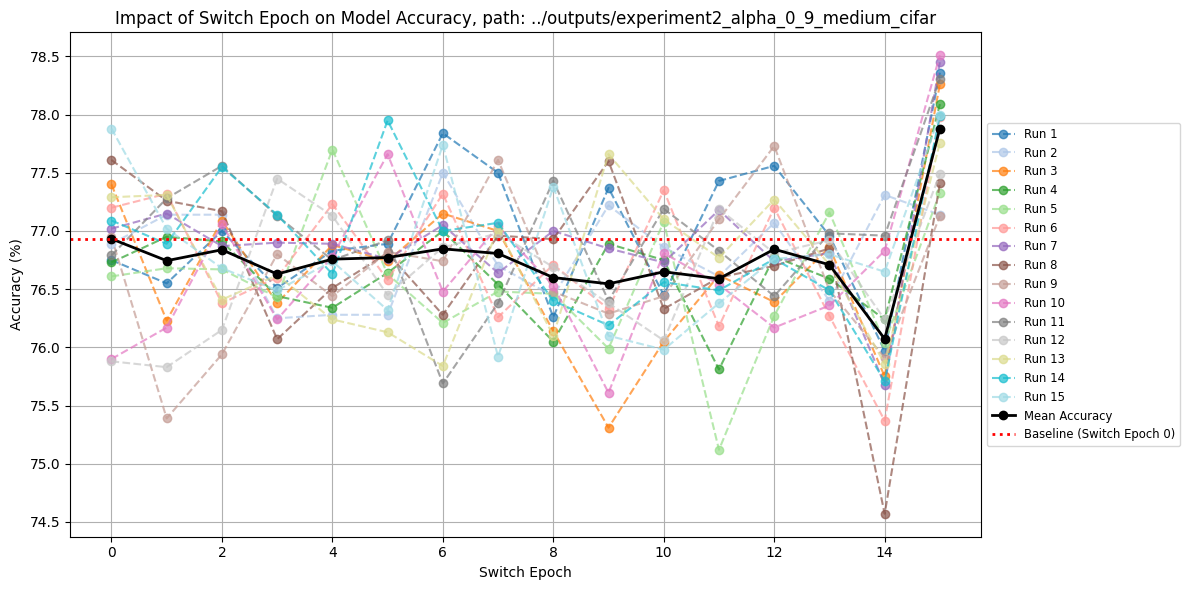

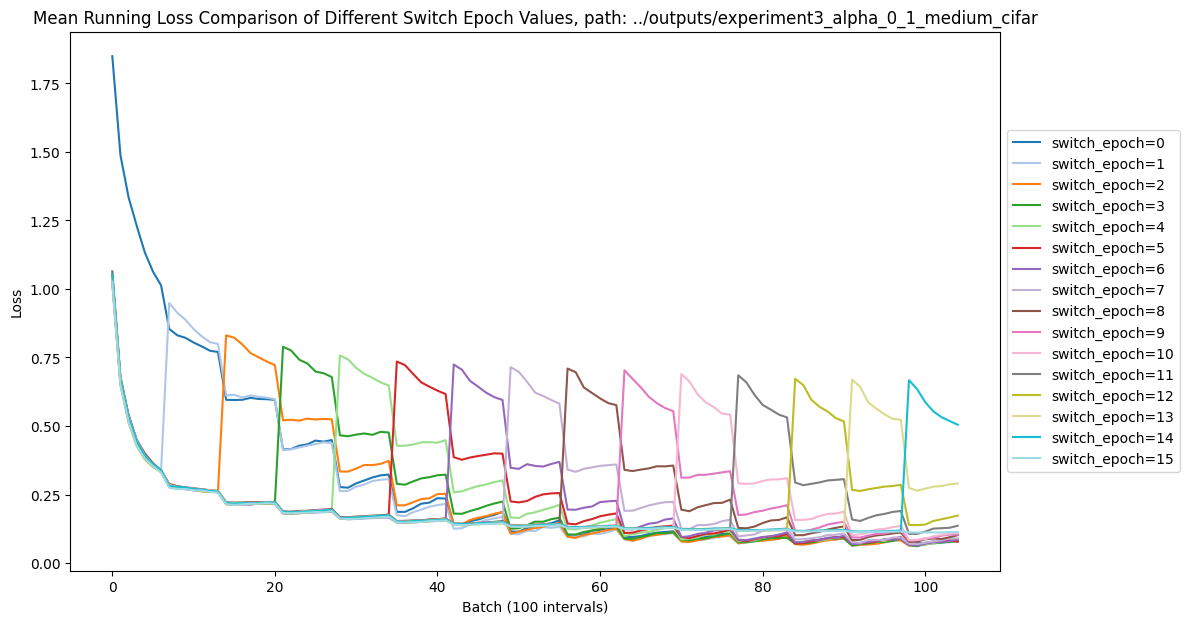

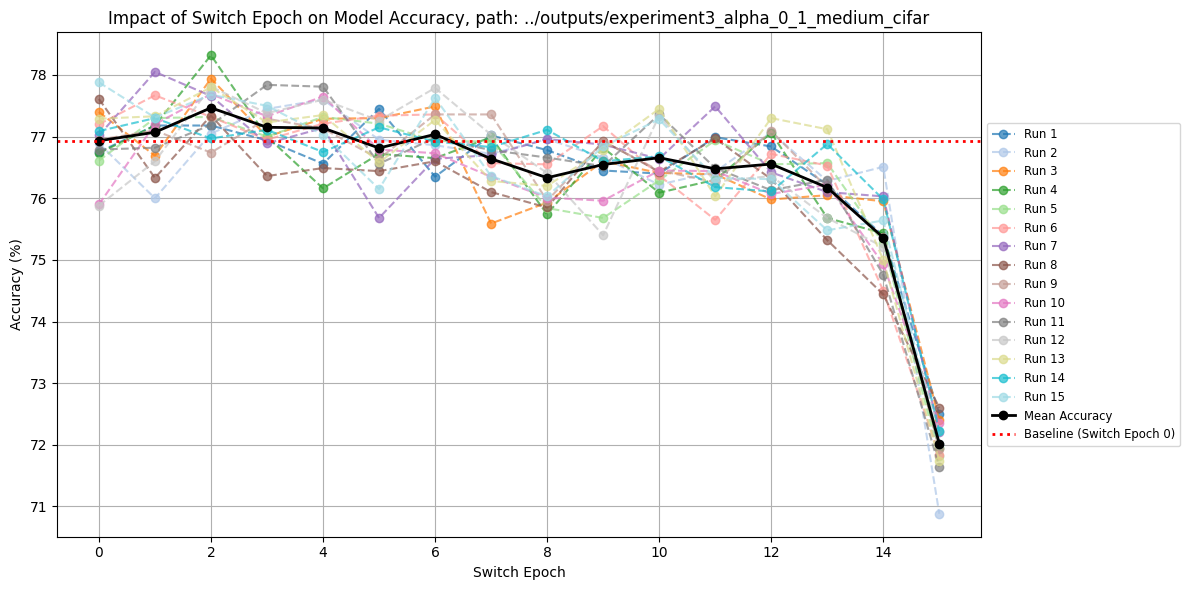

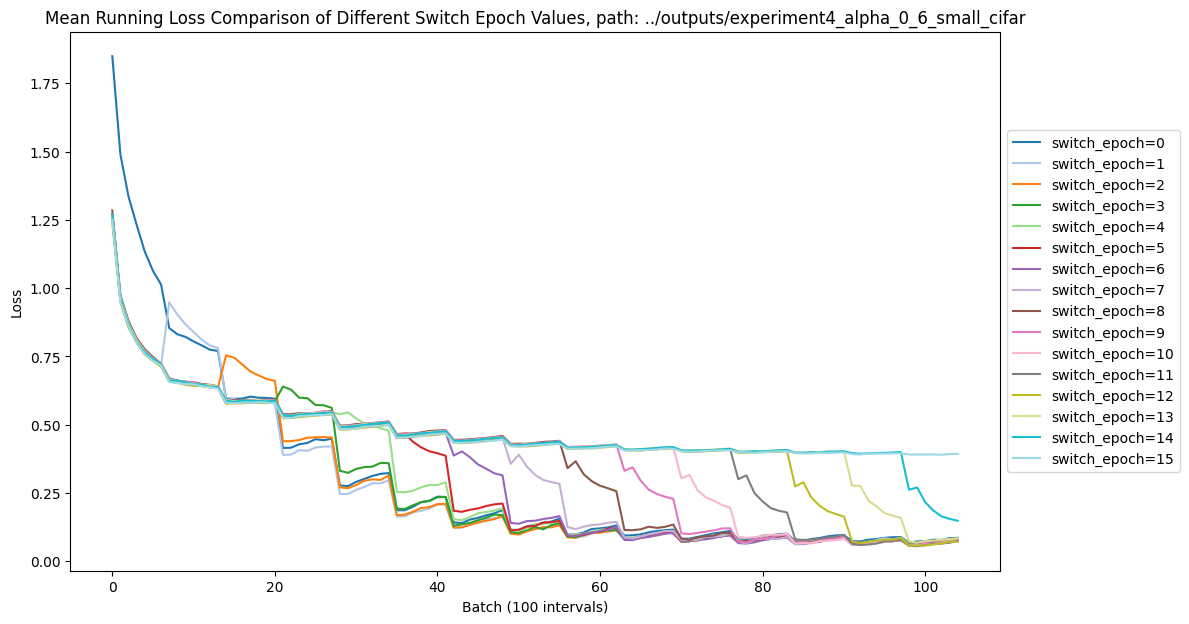

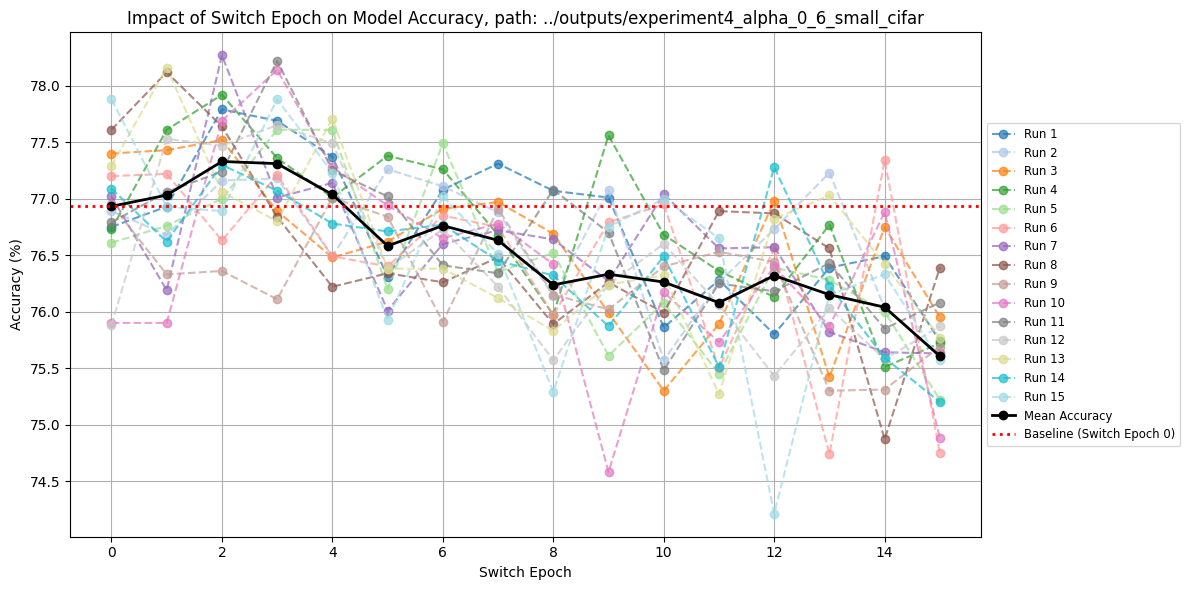

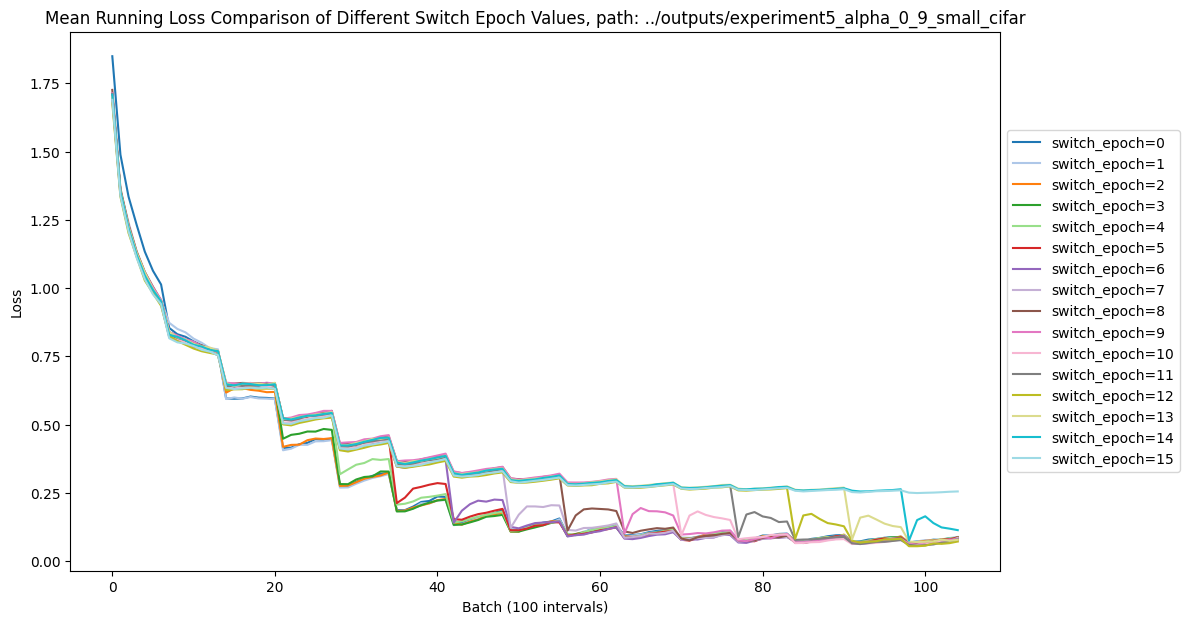

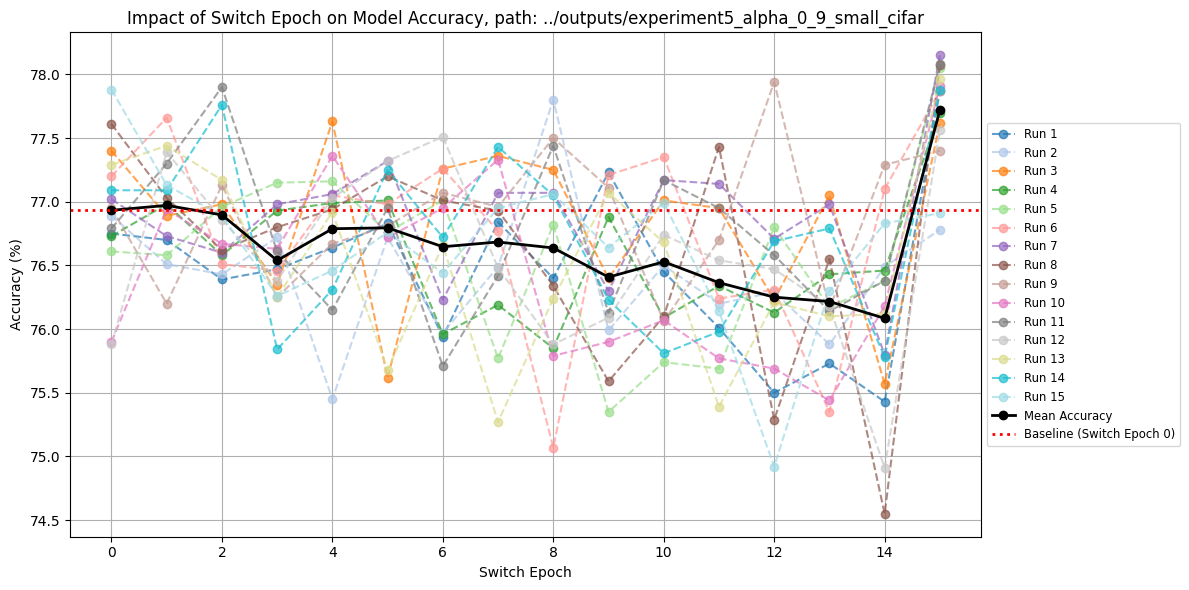

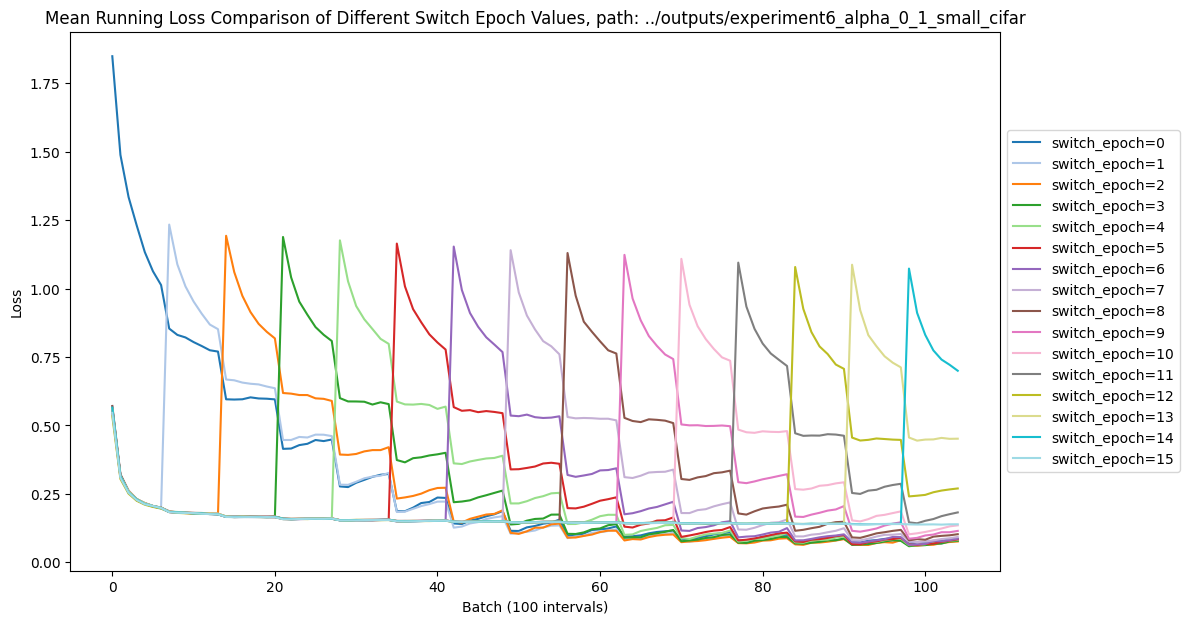

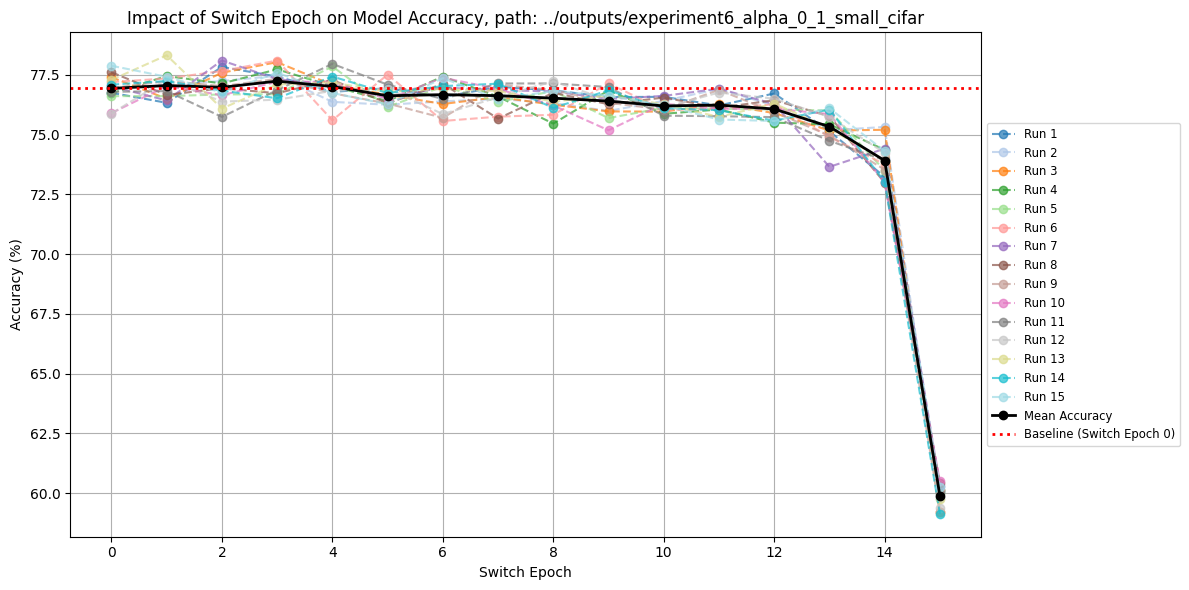

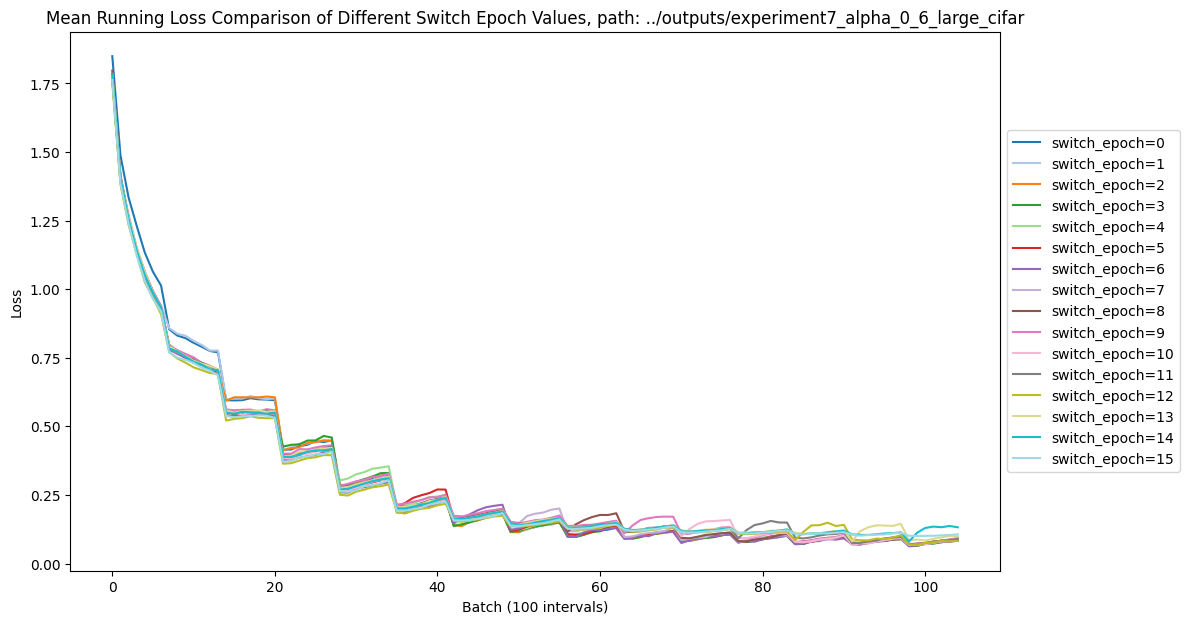

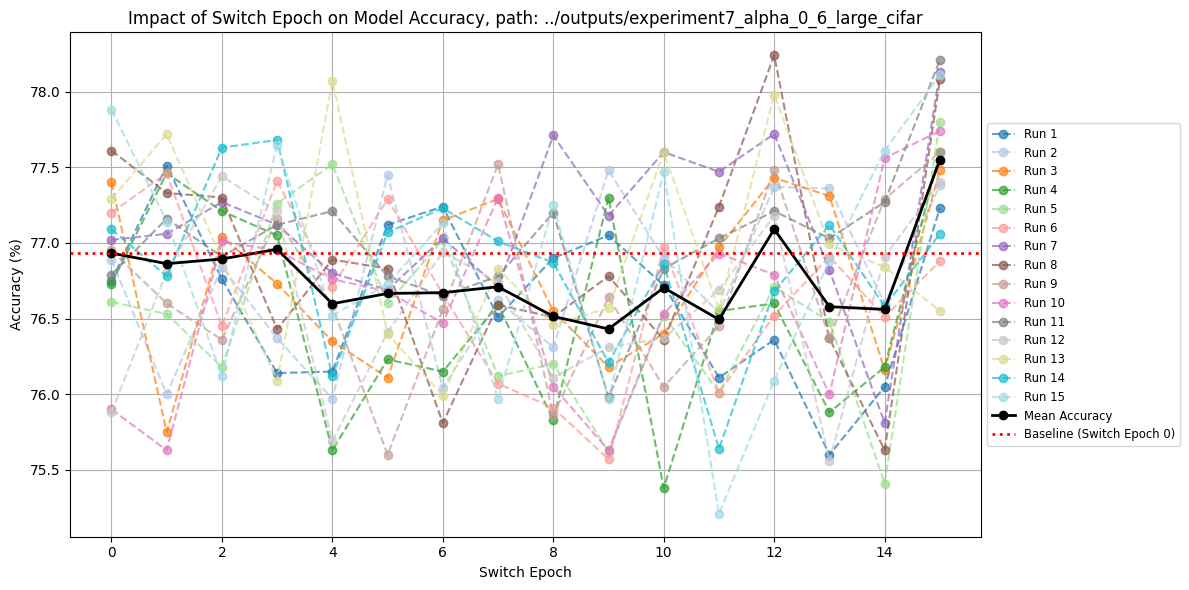

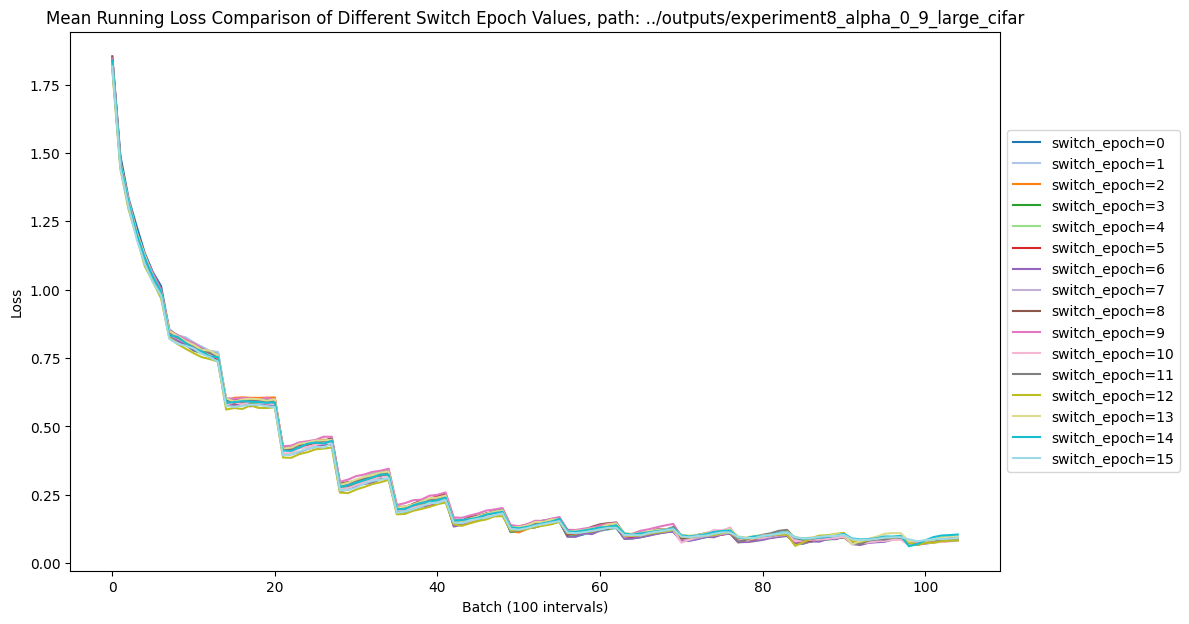

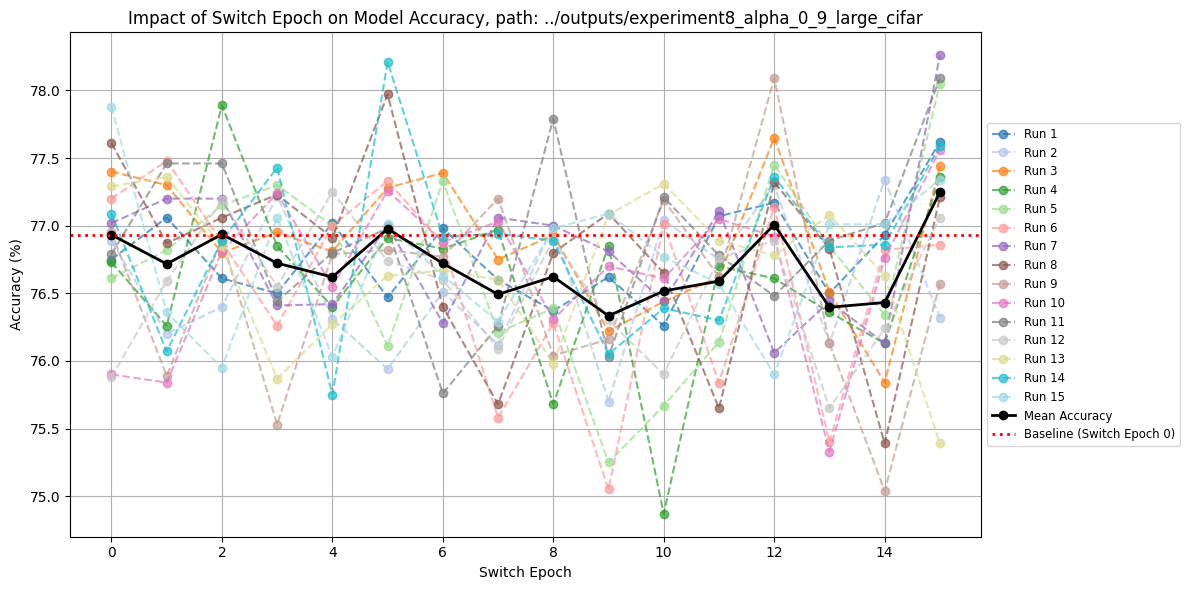

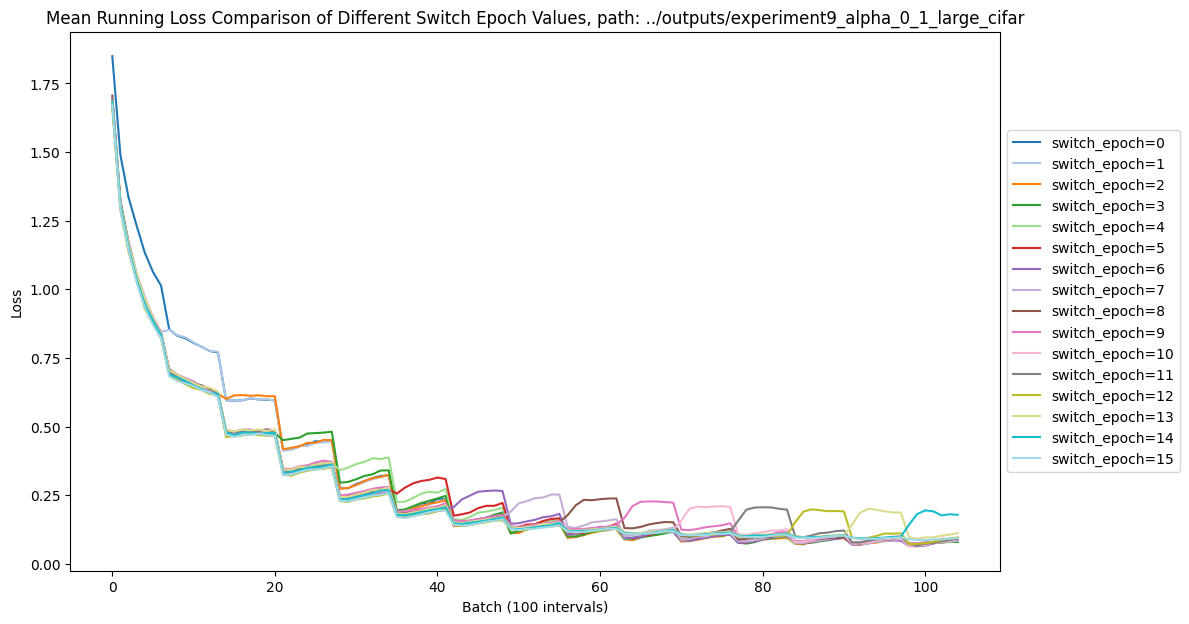

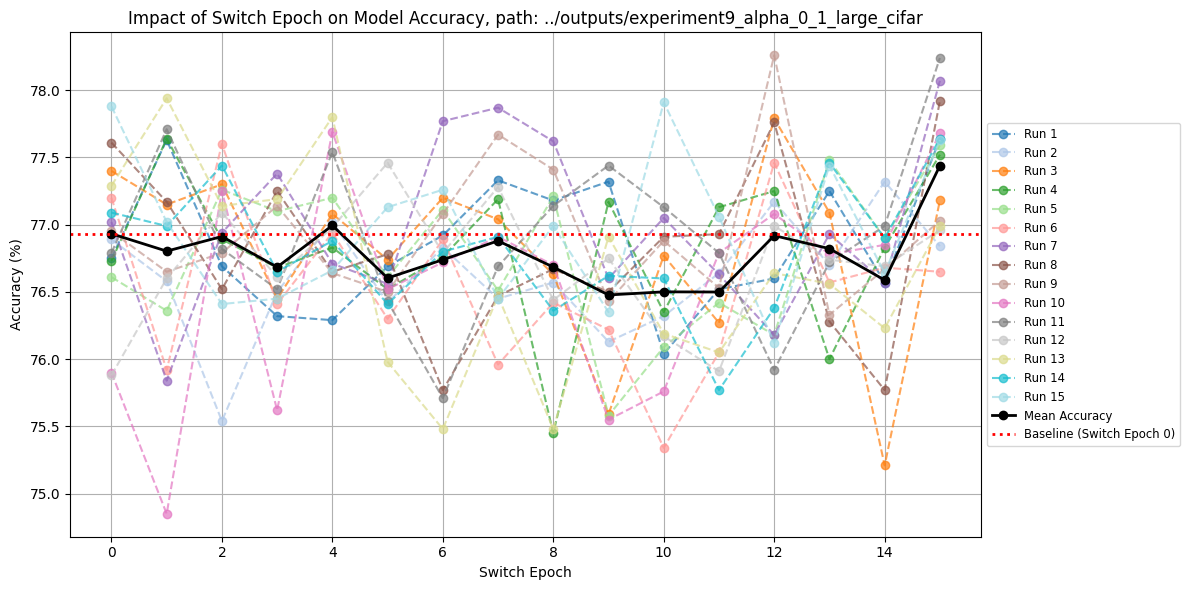

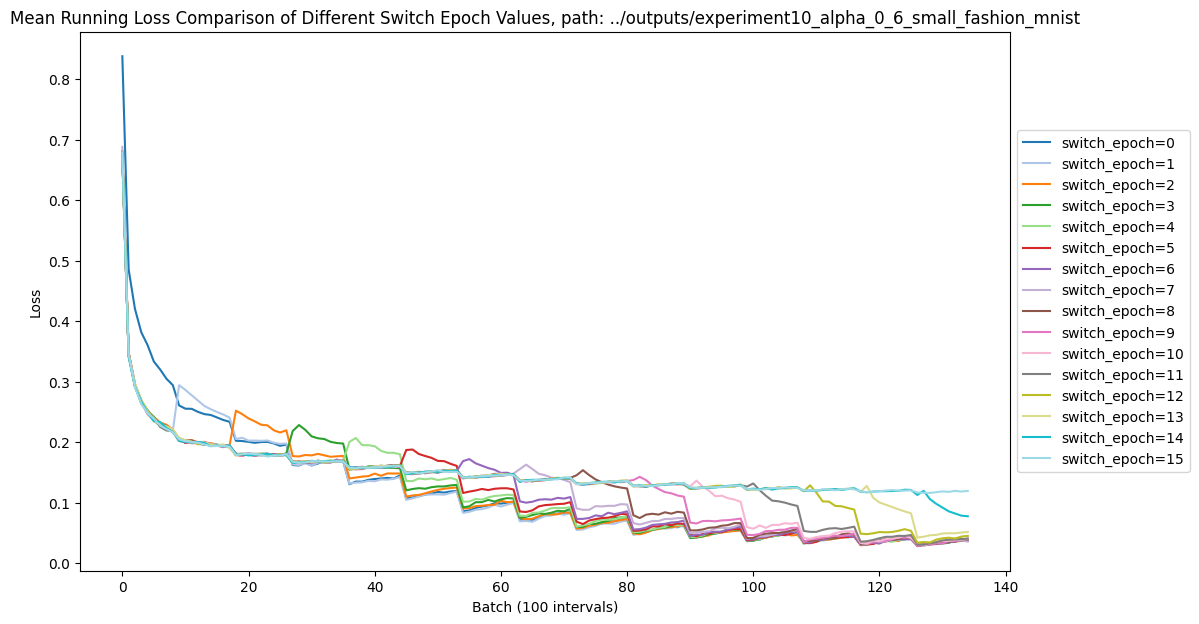

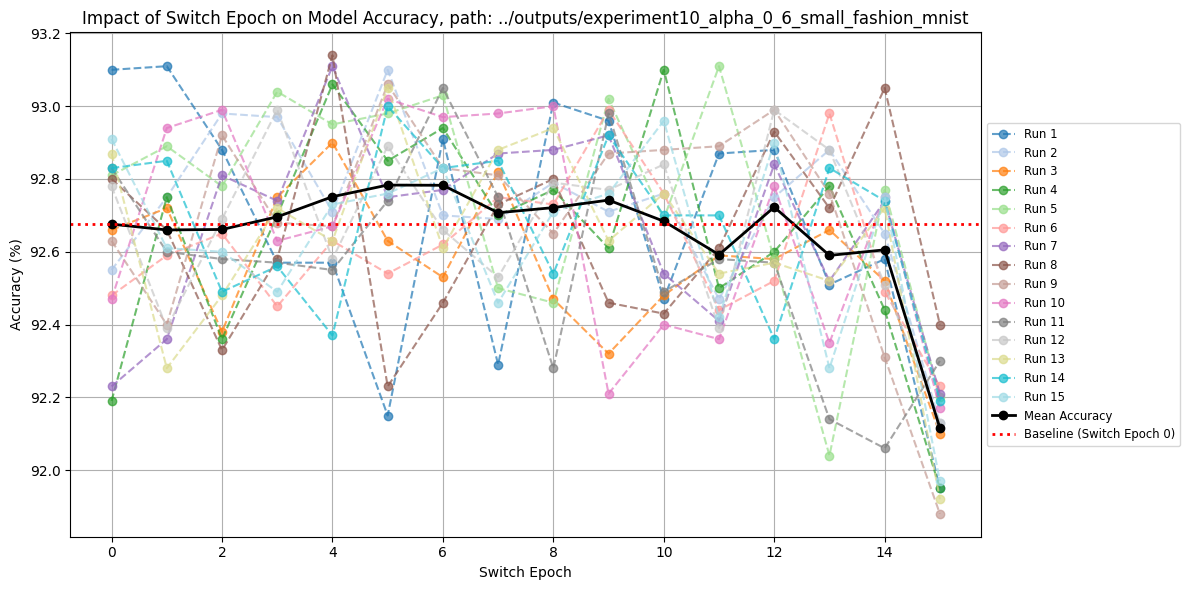

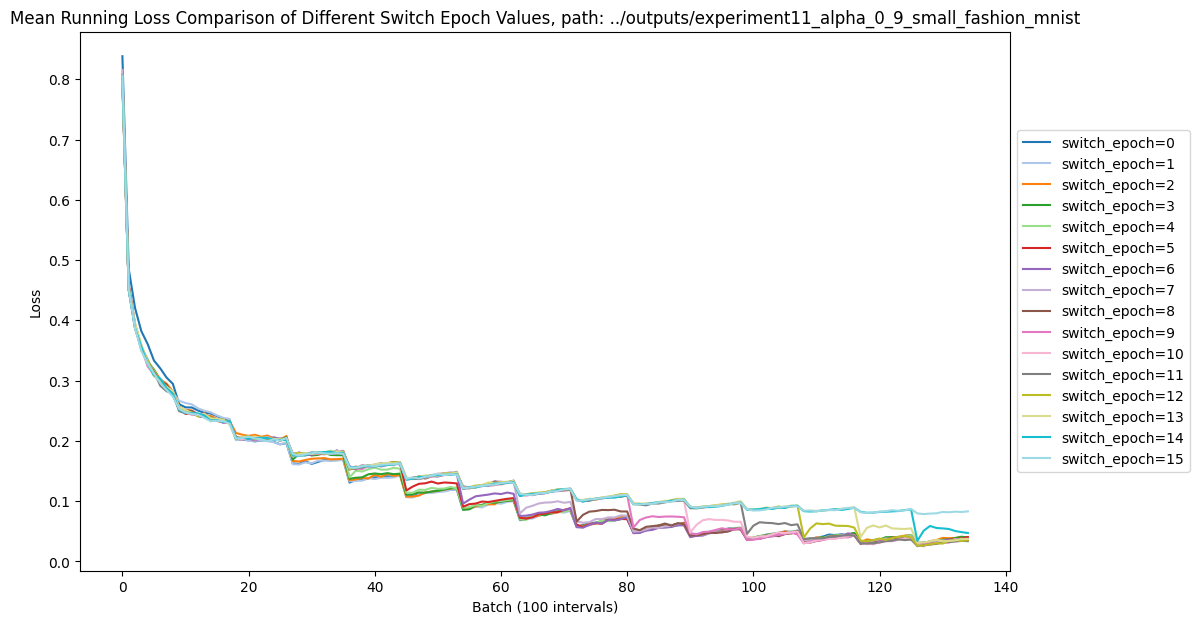

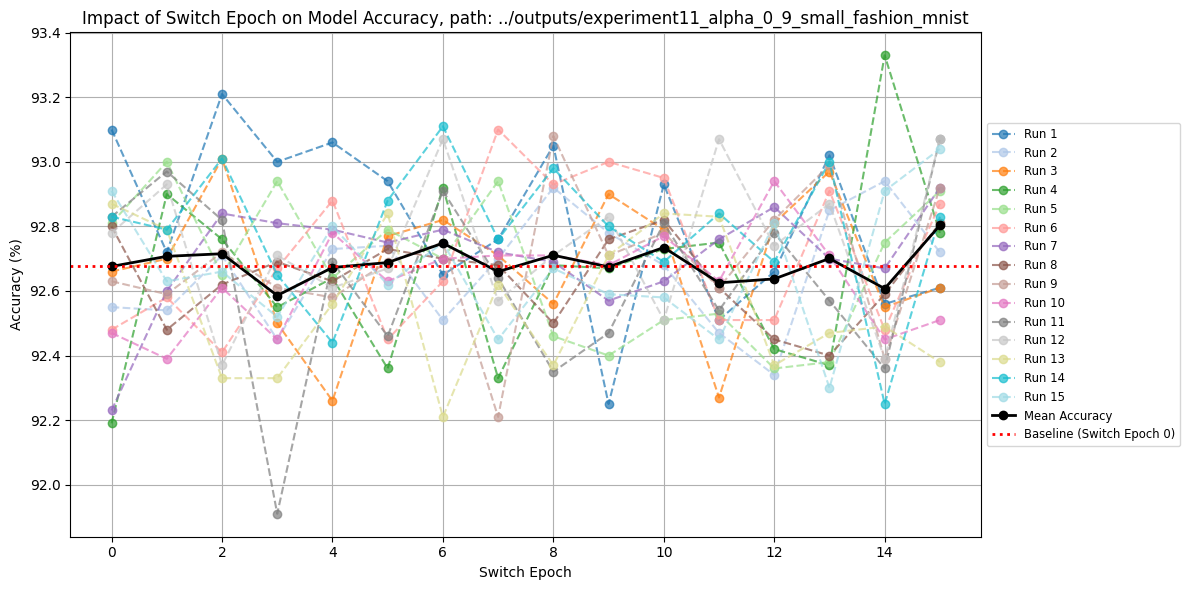

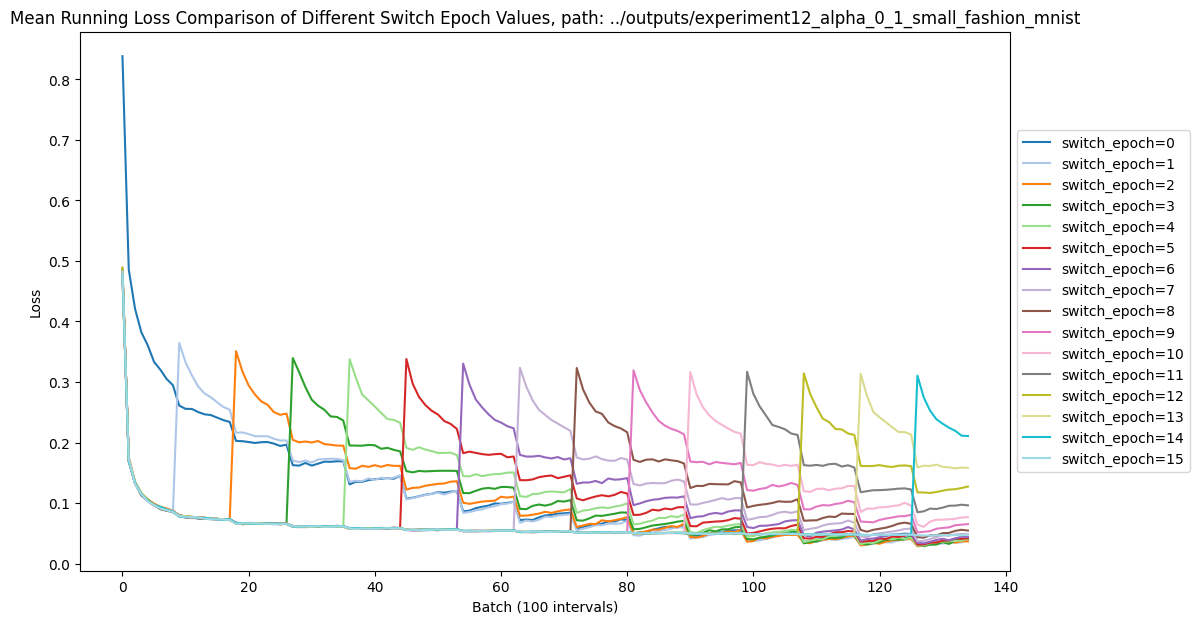

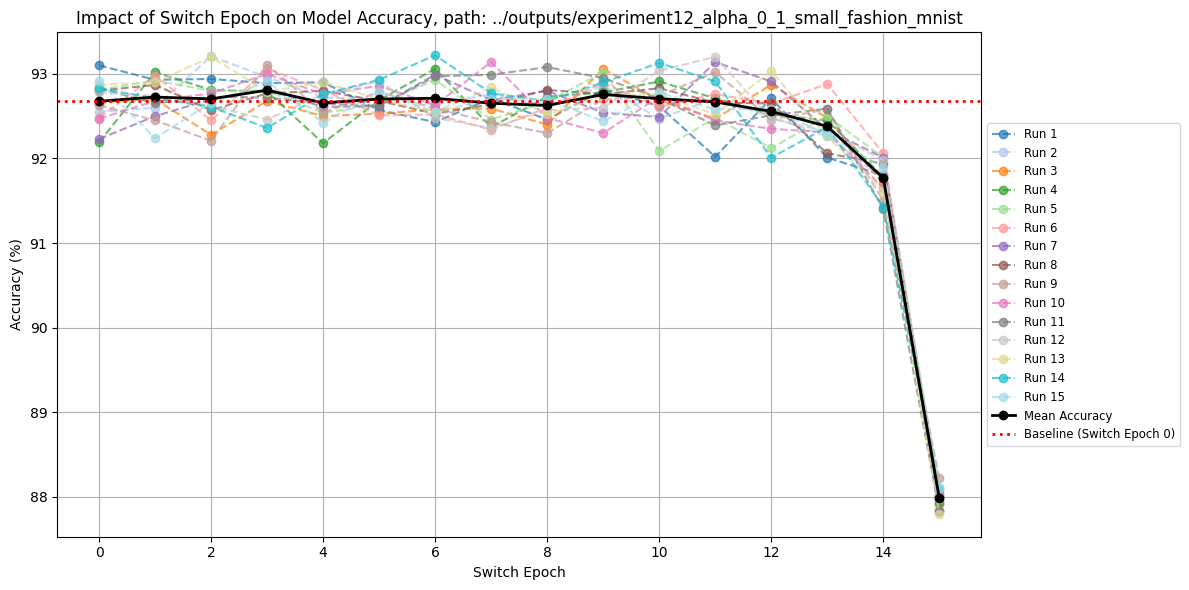

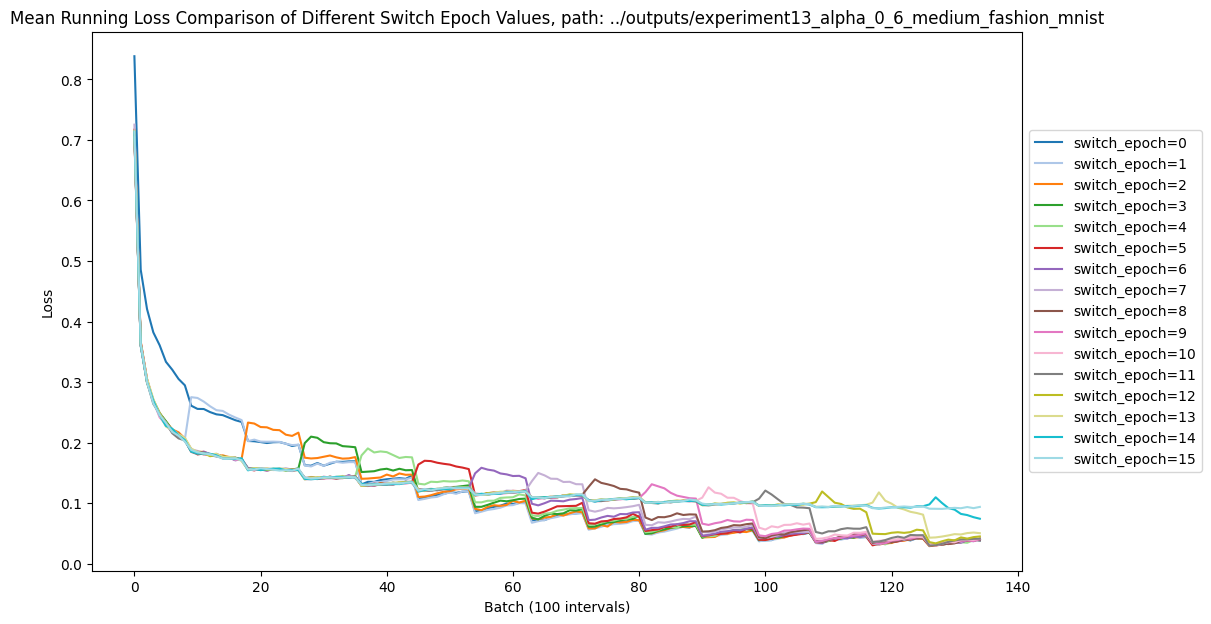

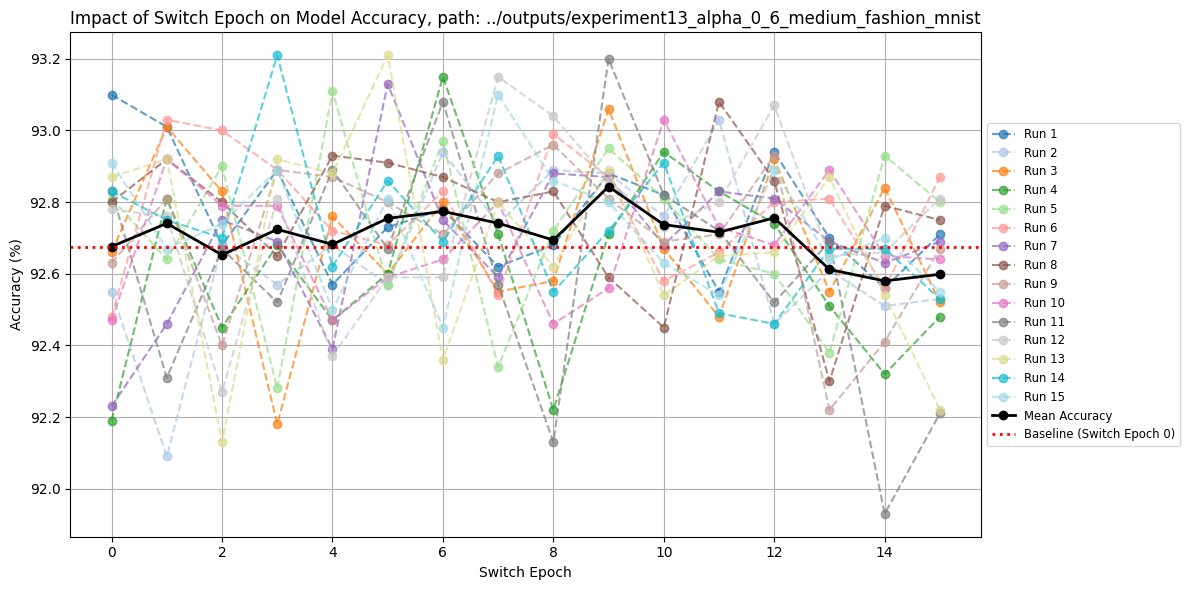

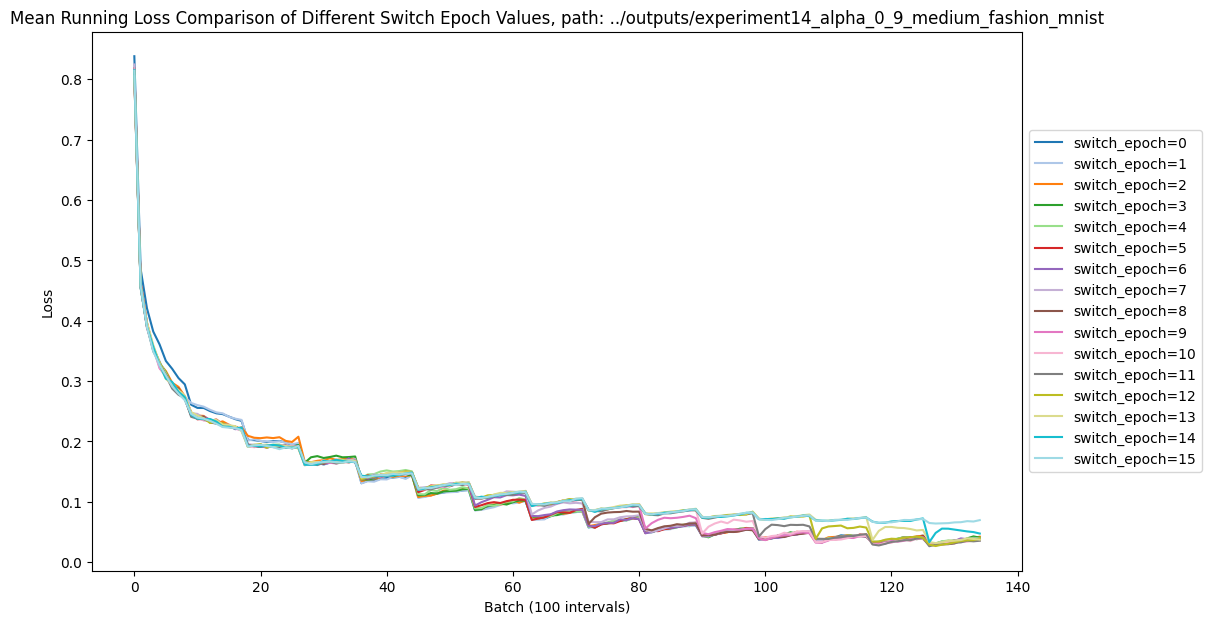

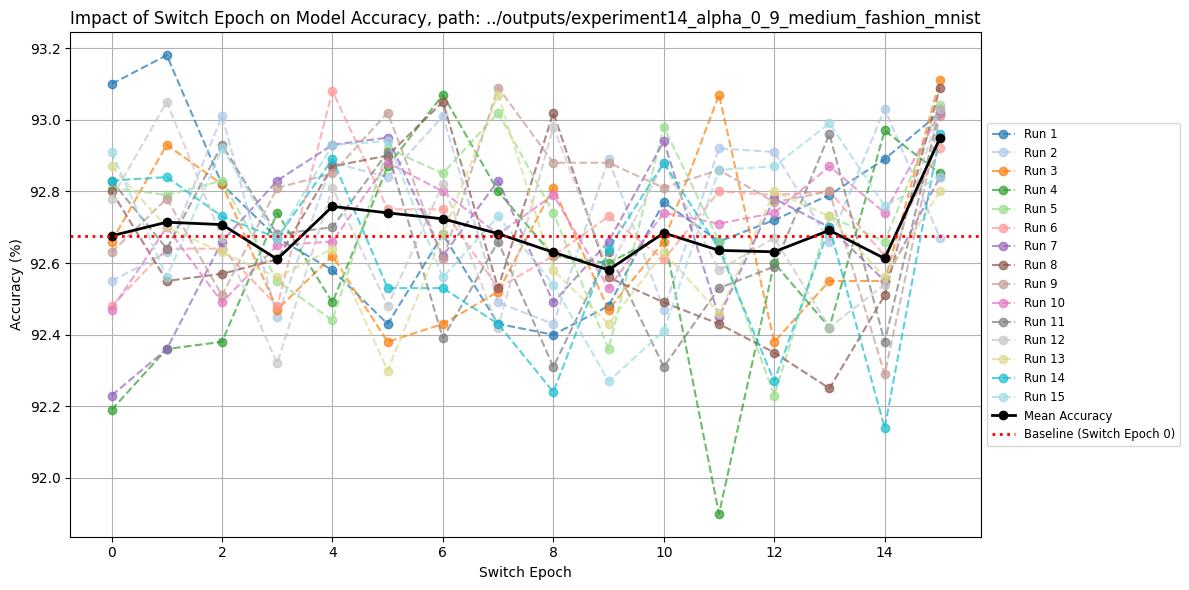

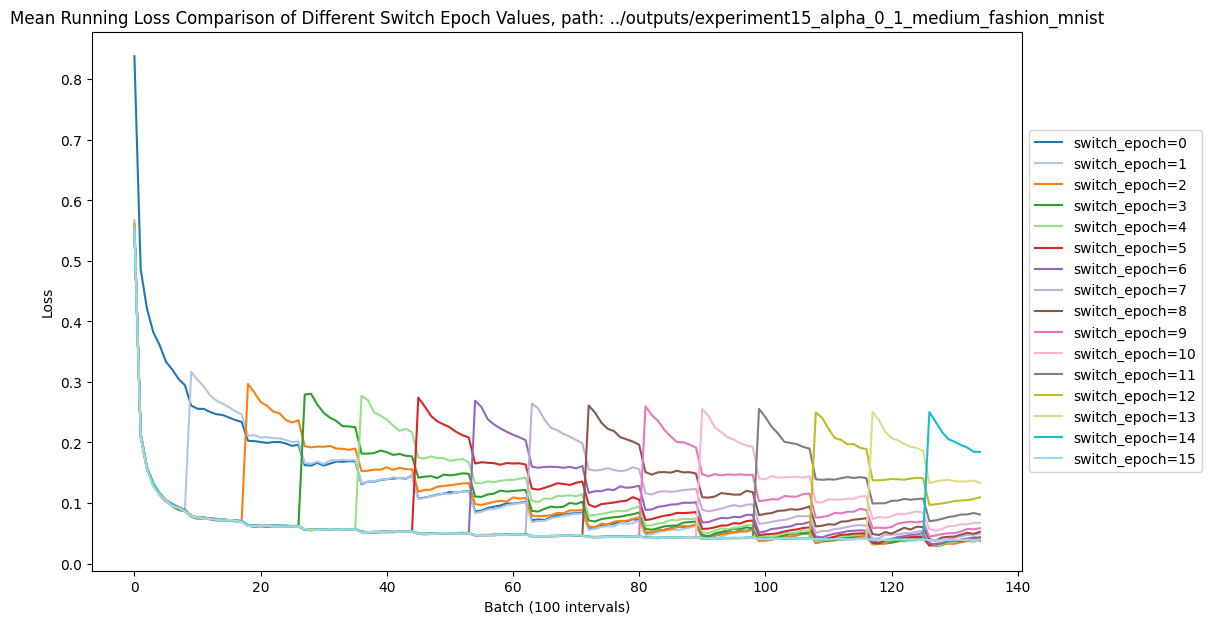

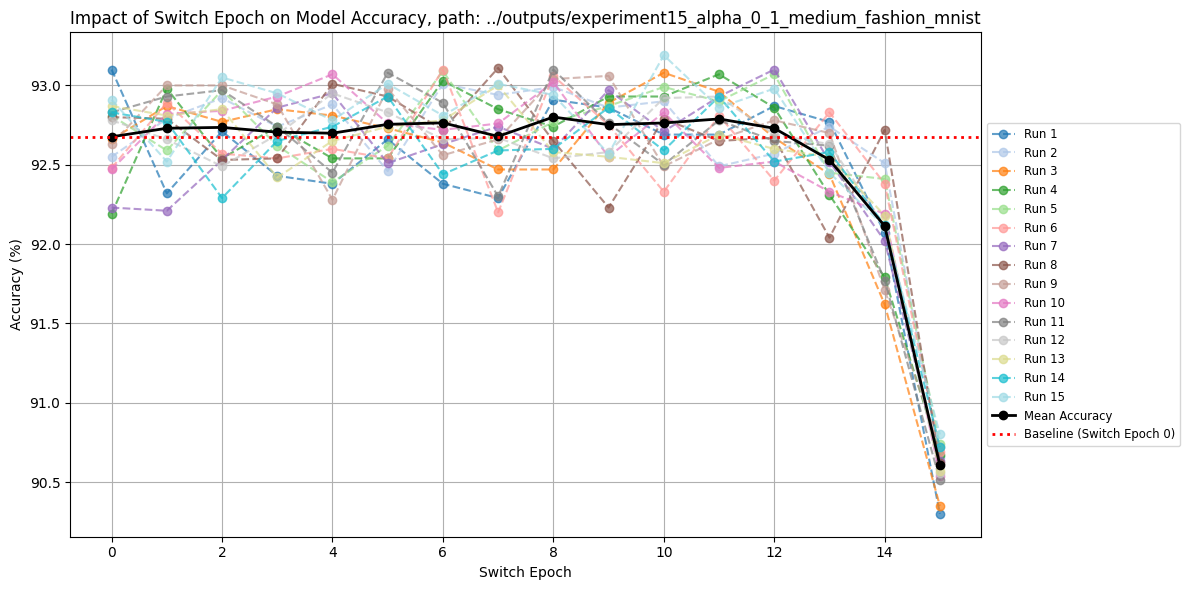

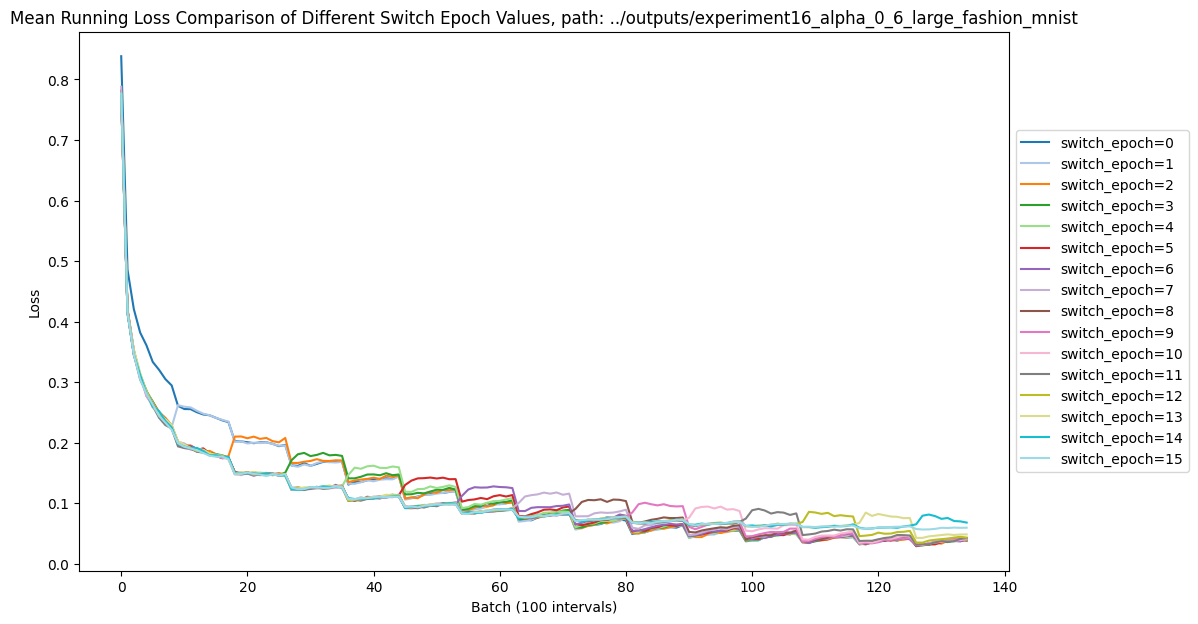

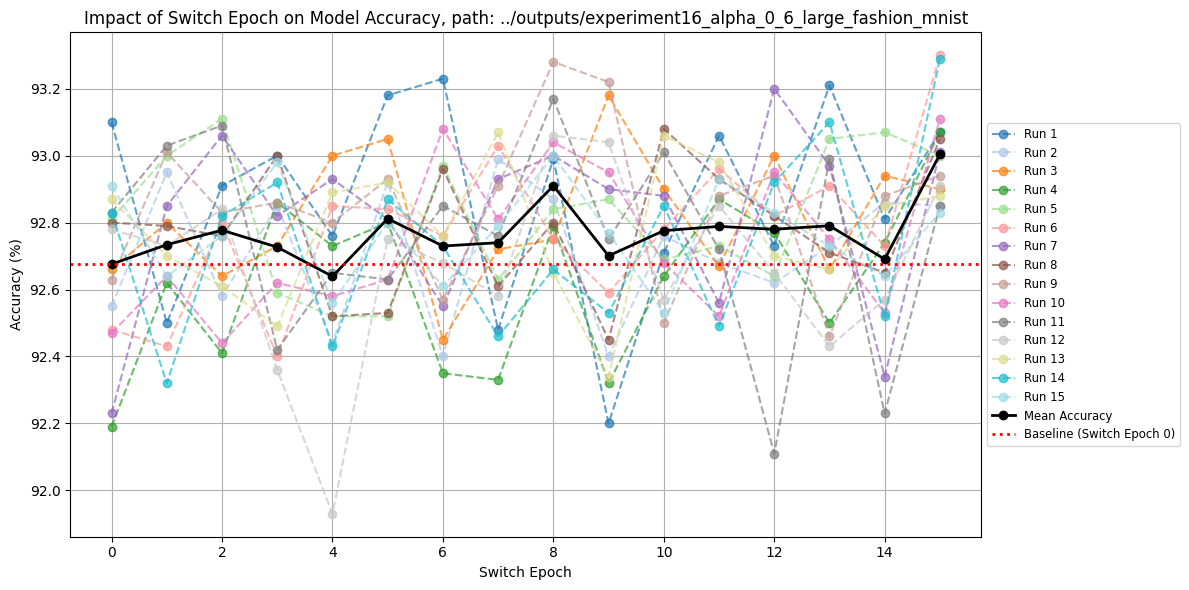

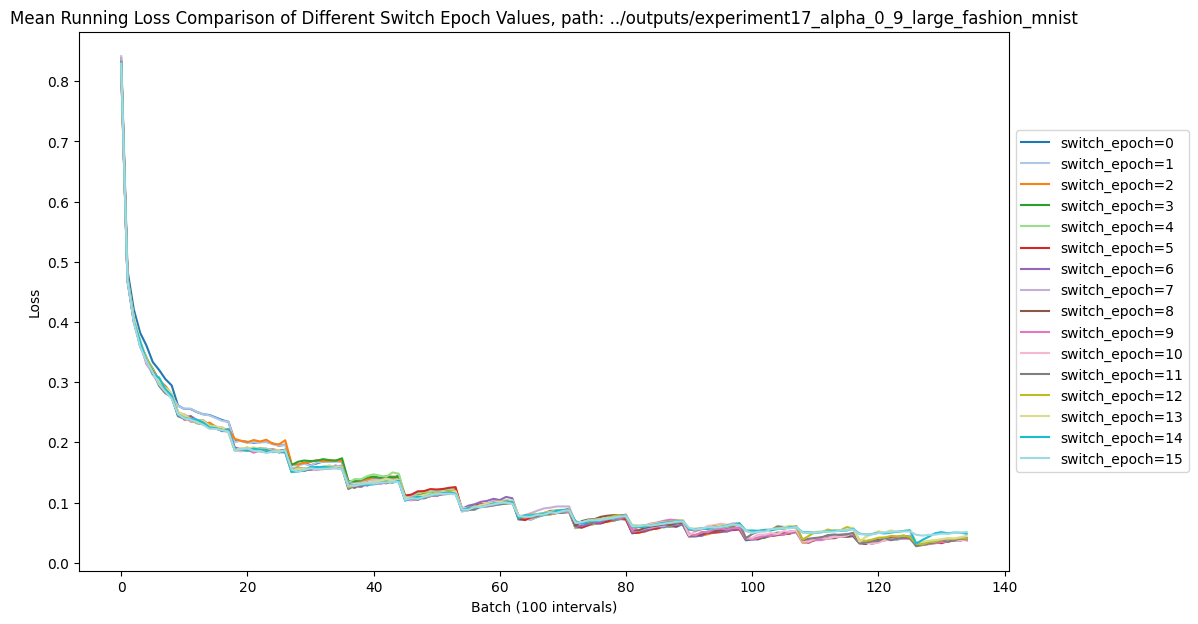

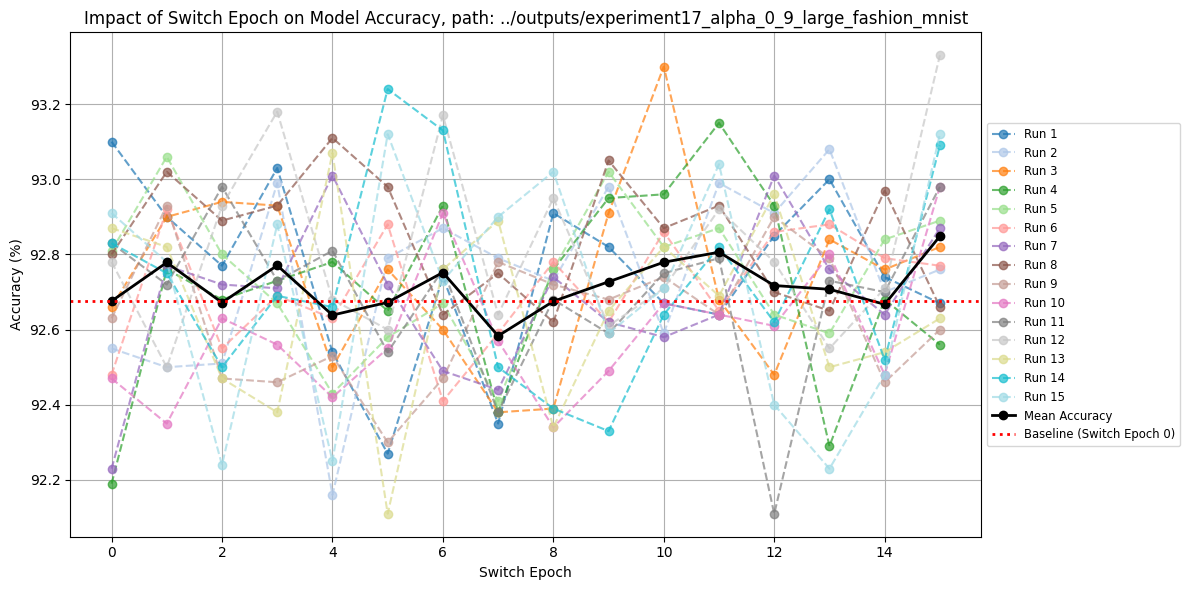

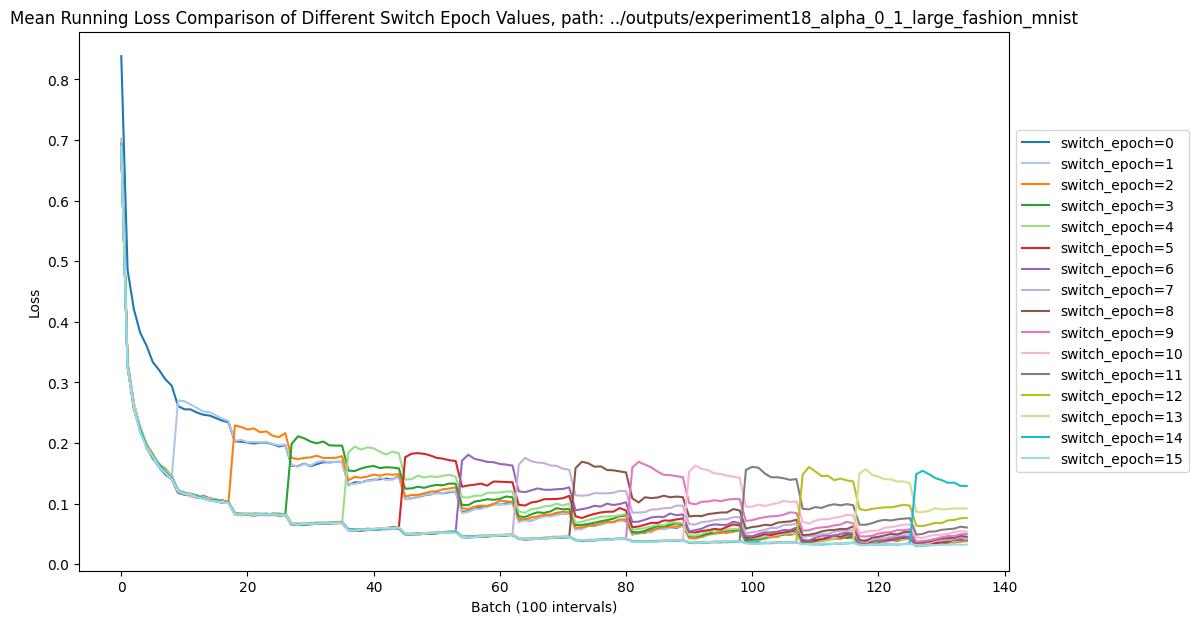

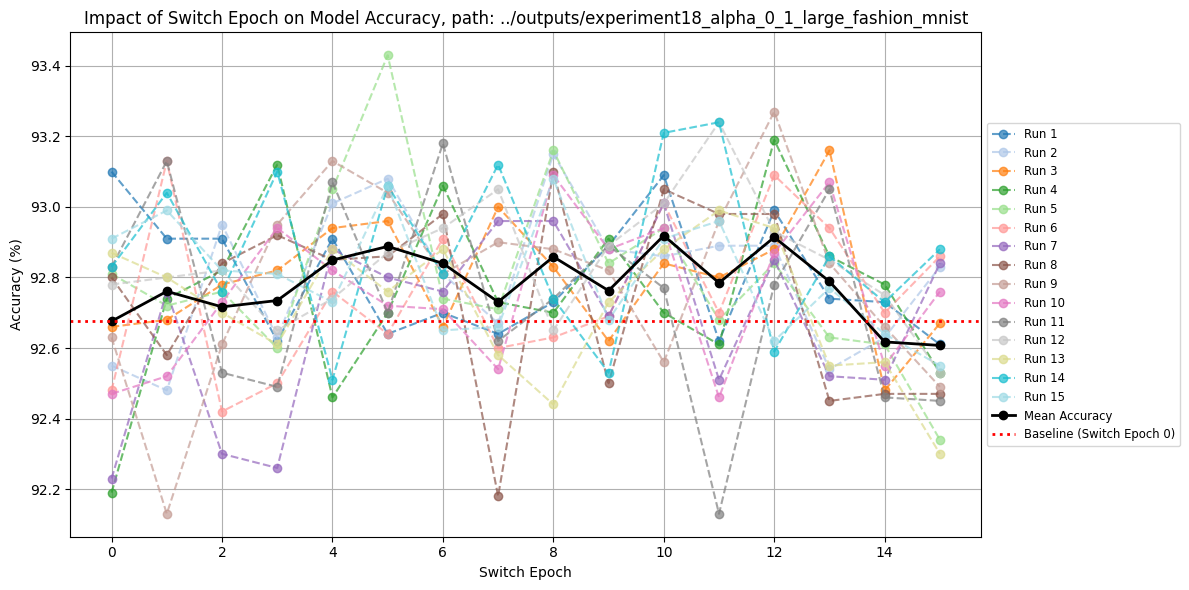

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import os
import re

output_dir = "../outputs"
def extract_experiment_number(name):
    match = re.search(r'experiment(\d+)', name)
    return int(match.group(1)) if match else float('inf')

experiment_paths = sorted(
    [os.path.join(output_dir, d) for d in os.listdir(output_dir) if d.startswith("experiment")],
    key=extract_experiment_number
)

seeds = np.loadtxt("../scripts/seeds.txt", dtype=int).tolist()

for experiment_path in experiment_paths:
    switch_epochs = 16
    run_accuracies = []
    all_losses = {epoch: [] for epoch in range(switch_epochs)}
    for run,seed in enumerate(seeds):
        results = {}
        switch_epoch_accuracies = []
        for switch_epoch in range(switch_epochs):
            if switch_epoch == 0:
                experiment_number = extract_experiment_number(experiment_path)
                student_dataset = "student_fashion_mnist" if experiment_number >= 10 else "student_cifar"
                path = f"../outputs/{student_dataset}/model_seed_{seed}"
            else:
                path = f"{experiment_path}/seed_{seed}/switch_epoch_{switch_epoch}"
            
            training_losses = np.loadtxt(f"{path}/training_losses.txt")
            results[switch_epoch] = training_losses
            accuracy = np.loadtxt(f"{path}/accuracy.txt")
            switch_epoch_accuracies.append(accuracy)
            all_losses[switch_epoch].append(training_losses)
        run_accuracies.append(switch_epoch_accuracies)
        
        # plt.figure(figsize=(12, 7))
        # colors = plt.cm.tab20(np.linspace(0, 1, switch_epochs))
        # for idx, (switch_epoch, losses) in enumerate(results.items()):
        #     plt.plot(losses, label=f'switch_epoch={switch_epoch}', color=colors[idx])
        # plt.xlabel('Batch (100 intervals)')
        # plt.ylabel('Loss')
        # plt.title(f'Running Loss Comparison of Different Switch Epoch Values, Run #{run+1}')
        # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        # plt.show()
    
    
    mean_losses = {epoch: np.mean(all_losses[epoch], axis=0) for epoch in range(switch_epochs)}
    plt.figure(figsize=(12, 7))
    colors = plt.cm.tab20(np.linspace(0, 1, switch_epochs))
    for idx, (switch_epoch, losses) in enumerate(mean_losses.items()):
        plt.plot(losses, label=f'switch_epoch={switch_epoch}', color=colors[idx])
    plt.xlabel('Batch (100 intervals)')
    plt.ylabel('Loss')
    plt.title(f'Mean Running Loss Comparison of Different Switch Epoch Values, path: {experiment_path}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    switch_epochs = list(range(15+1))
    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab20(np.linspace(0, 1, 15))
    for run in range(15):
        plt.plot(switch_epochs, run_accuracies[run], marker='o', linestyle='dashed', label=f'Run {run + 1}', color=colors[run], alpha=0.7)
    mean_accuracies = np.mean(run_accuracies, axis=0)
    plt.plot(switch_epochs, mean_accuracies, marker='o', linestyle='solid', color='black', linewidth=2, label='Mean Accuracy')
    plt.axhline(y=mean_accuracies[0], color='red', linestyle='dotted', linewidth=2, label='Baseline (Switch Epoch 0)')
    plt.xlabel('Switch Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Impact of Switch Epoch on Model Accuracy, path: {experiment_path}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    plt.tight_layout()
    plt.grid()
    plt.show()
    